<a href="https://colab.research.google.com/github/DiNOV-Tokyo/yolov5/blob/main/DL_torchvsion_DCGAN_car_ex4_SegmentationCarSelect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 現場で使える！　PyTorchPyTorch開発入門


##翔泳社

## 1.1 Google Drive をマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Colab\ Notebooks
#%mkdir yolo_train
%cd yolo_train

/content/drive/My Drive/Colab Notebooks
/content/drive/My Drive/Colab Notebooks/yolo_train


## 1.2 モジュール読み込み

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
import time

import numpy as np
from tqdm import tqdm
from PIL import Image
import os
import copy

#from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
from torchvision.utils import save_image

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

PyTorch Version:  1.9.0+cu111
Torchvision Version:  0.10.0+cu111
Setup complete. Using torch 1.9.0+cu111 _CudaDeviceProperties(name='Tesla K80', major=3, minor=7, total_memory=11441MB, multi_processor_count=13)


device(type='cuda', index=0)

##DCGANによる画像生成

Stanfrod Cars Datasetから選別した画像をセマンティックセグメンテーションにて車だけを抜き出し、背景を白色にした画像を用いる。

用いる画像ファイルの数を確認。

In [4]:

DIR = 'pspnet_car_data/jpg/'

print(sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR)))

471


In [5]:
#img_data = ImageFolder("./stanford-car",
img_data = ImageFolder("./pspnet_car_data",
    transform=transforms.Compose([
        transforms.Resize(140),
#        transforms.Resize(160),
        transforms.CenterCrop(128),
        transforms.ToTensor()
]))

#batch_size = 8
batch_size = 16
#batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size,
                        shuffle=True)

データの確認

In [6]:
batch_iterator = iter(img_loader)
imges = next(batch_iterator)
print(imges[0].size())

torch.Size([16, 3, 128, 128])


画像生成モデル

In [7]:
nz = 100
ngf = 32

class GNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8,   
                               4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 8, 
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf * 2, ngf,
                               4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(ngf, 3,
                               4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        out = self.main(x)
        return out

識別モデル

In [8]:
ndf = 128
ndf = 32

class DNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 2, 0, bias=False),
        )

    def forward(self, x):
        out = self.main(x)
        return out.squeeze()

訓練関数の作成

In [9]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

# Adamのパラメータは元論文の提案値
opt_d = optim.Adam(d.parameters(),
    lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(),
    lr=0.0002, betas=(0.5, 0.999))

# クロスエントロピーを計算するための補助変数など
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

# モニタリング用のz
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [10]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader):
    # 生成モデル、識別モデルの目的関数の追跡用の配列
    log_loss_g = []
    log_loss_d = []
#    for real_img, _ in loader:
    for real_img, _ in tqdm(loader):
        batch_len = len(real_img)
        
         # 実際の画像をGPUにコピー
        real_img = real_img.to("cuda:0")
        
         # 偽画像を乱数と生成モデルから作る
        z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
        fake_img = g(z)
        
        # 後で使用するので偽画像の値のみ取り出しておく
        fake_img_tensor = fake_img.detach()
        # 偽画像に対する生成モデルの評価関数を計算する
        out = d(fake_img)

        loss_g = loss_f(out, ones[: batch_len])
        log_loss_g.append(loss_g.item())
        
        # 計算グラフが生成モデルと識別モデルの両方に
        # 依存しているので両者とも勾配をクリアしてから
        # 微分の計算とパラメータ更新を行う
        d.zero_grad(), g.zero_grad()
        loss_g.backward()
        opt_g.step()

        # 実際の画像に対する識別モデルの評価関数を計算
        real_out = d(real_img)

        loss_d_real = loss_f(real_out, ones[: batch_len])
        
        # PyTorchでは同じTensorを含んだ計算グラフに対して
        # 2回backwardを行うことができないので保存してあった
        # Tensorを使用して無駄な計算を省く
        fake_img = fake_img_tensor
        
        # 偽画像に対する識別モデルの評価関数の計算
        fake_out = d(fake_img_tensor)
        loss_d_fake = loss_f(fake_out, zeros[: batch_len])
        
        # 実偽の評価関数の合計値
        loss_d = loss_d_real + loss_d_fake
        log_loss_d.append(loss_d.item())
        
        # 識別モデルの微分計算とパラメータ更新
        d.zero_grad(), g.zero_grad()
        loss_d.backward()
        opt_d.step()

    return mean(log_loss_g), mean(log_loss_d)

訓練開始

In [11]:

import datetime

for epoch in range(300):
    train_dcgan(g, d, opt_g, opt_d, img_loader)
    print("{} Epoch {}: ".format(datetime.datetime.now(), epoch))
    # 10回の繰り返しごとに学習結果を保存する
    if epoch % 10 == 0:
        # パラメータの保存
        #torch.save(
        #    g.state_dict(),
         #   "cars_train/g_{:03d}.prm".format(epoch),
          #  pickle_protocol=4)
        #torch.save(
         #   d.state_dict(),
          #  "cars_train/d_{:03d}.prm".format(epoch),
           # pickle_protocol=4)
        # モニタリング用のzから生成した画像を保存
        generated_img = g(fixed_z)
        save_image(generated_img,
                   "./pspnet_car_data/b16-{:03d}.jpg".format(epoch))

100%|██████████| 30/30 [01:49<00:00,  3.64s/it]


2021-10-20 08:26:07.818612 Epoch 0: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:26:23.859357 Epoch 1: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:26:39.739439 Epoch 2: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:26:55.682429 Epoch 3: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:27:11.763327 Epoch 4: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:27:27.771142 Epoch 5: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:27:43.800589 Epoch 6: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:28:00.044764 Epoch 7: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:28:16.015820 Epoch 8: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:28:32.033326 Epoch 9: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:28:47.940427 Epoch 10: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:29:04.006192 Epoch 11: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:29:19.997730 Epoch 12: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:29:36.077358 Epoch 13: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:29:52.246769 Epoch 14: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:30:08.390694 Epoch 15: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:30:24.327373 Epoch 16: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:30:40.380875 Epoch 17: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:30:56.235548 Epoch 18: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:31:12.178113 Epoch 19: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:31:28.172399 Epoch 20: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:31:44.314497 Epoch 21: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:32:00.417417 Epoch 22: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:32:16.588225 Epoch 23: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:32:32.578345 Epoch 24: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:32:48.573577 Epoch 25: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:33:04.556302 Epoch 26: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:33:20.597817 Epoch 27: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:33:36.524267 Epoch 28: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:33:52.721340 Epoch 29: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:34:08.745506 Epoch 30: 


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


2021-10-20 08:34:25.087869 Epoch 31: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:34:41.351345 Epoch 32: 


100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


2021-10-20 08:34:57.816373 Epoch 33: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:35:13.991566 Epoch 34: 


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


2021-10-20 08:35:30.326345 Epoch 35: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:35:46.423010 Epoch 36: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:36:02.281374 Epoch 37: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:36:18.062185 Epoch 38: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 08:36:33.746460 Epoch 39: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:36:49.605087 Epoch 40: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:37:05.505969 Epoch 41: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:37:21.442658 Epoch 42: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:37:37.270925 Epoch 43: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:37:53.105143 Epoch 44: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:38:09.116542 Epoch 45: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:38:25.131616 Epoch 46: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:38:41.140305 Epoch 47: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:38:57.206308 Epoch 48: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:39:13.174369 Epoch 49: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:39:29.063964 Epoch 50: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:39:45.066151 Epoch 51: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:40:01.094375 Epoch 52: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:40:17.171585 Epoch 53: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:40:33.299723 Epoch 54: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:40:49.387107 Epoch 55: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:41:05.591810 Epoch 56: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:41:21.497795 Epoch 57: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:41:37.700986 Epoch 58: 


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


2021-10-20 08:41:54.007154 Epoch 59: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:42:10.247518 Epoch 60: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:42:26.429169 Epoch 61: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:42:42.521518 Epoch 62: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:42:58.560831 Epoch 63: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:43:14.754520 Epoch 64: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:43:30.808782 Epoch 65: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:43:46.935621 Epoch 66: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:44:03.102735 Epoch 67: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:44:19.337291 Epoch 68: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:44:35.602438 Epoch 69: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:44:51.817603 Epoch 70: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:45:08.020638 Epoch 71: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:45:24.180256 Epoch 72: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:45:40.150962 Epoch 73: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:45:56.226301 Epoch 74: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:46:12.297035 Epoch 75: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:46:28.326224 Epoch 76: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:46:44.184877 Epoch 77: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:47:00.091394 Epoch 78: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:47:16.147976 Epoch 79: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:47:32.170387 Epoch 80: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:47:48.261693 Epoch 81: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:48:04.315489 Epoch 82: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:48:20.470239 Epoch 83: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:48:36.656937 Epoch 84: 


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


2021-10-20 08:48:52.940375 Epoch 85: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:49:09.058195 Epoch 86: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:49:25.227703 Epoch 87: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:49:41.356423 Epoch 88: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:49:57.529050 Epoch 89: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:50:13.629755 Epoch 90: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:50:29.944294 Epoch 91: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:50:46.046868 Epoch 92: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 08:51:02.295304 Epoch 93: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:51:18.426388 Epoch 94: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:51:34.586412 Epoch 95: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:51:50.777635 Epoch 96: 


100%|██████████| 30/30 [00:16<00:00,  1.80it/s]


2021-10-20 08:52:07.474979 Epoch 97: 


100%|██████████| 30/30 [00:16<00:00,  1.82it/s]


2021-10-20 08:52:23.975711 Epoch 98: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:52:40.080992 Epoch 99: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:52:56.203452 Epoch 100: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:53:12.177144 Epoch 101: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 08:53:27.841597 Epoch 102: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:53:43.651090 Epoch 103: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:53:59.439974 Epoch 104: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:54:15.313283 Epoch 105: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 08:54:31.016150 Epoch 106: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 08:54:46.719531 Epoch 107: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 08:55:02.462956 Epoch 108: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:55:18.258830 Epoch 109: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:55:34.082361 Epoch 110: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:55:49.941833 Epoch 111: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:56:05.786897 Epoch 112: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 08:56:21.596633 Epoch 113: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:56:37.467020 Epoch 114: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:56:53.332600 Epoch 115: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:57:09.294281 Epoch 116: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:57:25.179204 Epoch 117: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:57:41.177303 Epoch 118: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:57:57.143200 Epoch 119: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 08:58:13.238612 Epoch 120: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:58:29.197910 Epoch 121: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:58:45.048526 Epoch 122: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 08:59:00.973584 Epoch 123: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 08:59:17.077327 Epoch 124: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:59:33.074433 Epoch 125: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 08:59:49.076105 Epoch 126: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:00:05.231525 Epoch 127: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:00:21.375134 Epoch 128: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:00:37.518845 Epoch 129: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:00:53.785044 Epoch 130: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:01:09.975859 Epoch 131: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:01:26.169023 Epoch 132: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:01:42.205831 Epoch 133: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:01:58.300967 Epoch 134: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:02:14.457478 Epoch 135: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:02:30.666536 Epoch 136: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:02:46.855242 Epoch 137: 


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


2021-10-20 09:03:03.188196 Epoch 138: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:03:19.403895 Epoch 139: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:03:35.647492 Epoch 140: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:03:51.910667 Epoch 141: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:04:08.073242 Epoch 142: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:04:24.326455 Epoch 143: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:04:40.484512 Epoch 144: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:04:56.592950 Epoch 145: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:05:12.824573 Epoch 146: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:05:28.996555 Epoch 147: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:05:45.112860 Epoch 148: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:06:01.338795 Epoch 149: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:06:17.450593 Epoch 150: 


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


2021-10-20 09:06:33.774229 Epoch 151: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:06:49.966003 Epoch 152: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:07:06.184659 Epoch 153: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:07:22.336316 Epoch 154: 


100%|██████████| 30/30 [00:16<00:00,  1.84it/s]


2021-10-20 09:07:38.671119 Epoch 155: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:07:54.902625 Epoch 156: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:08:11.131896 Epoch 157: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:08:27.270209 Epoch 158: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:08:43.505462 Epoch 159: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:08:59.752518 Epoch 160: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:09:16.018642 Epoch 161: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:09:32.086362 Epoch 162: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:09:48.261345 Epoch 163: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:10:04.396363 Epoch 164: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:10:20.429341 Epoch 165: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:10:36.431325 Epoch 166: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:10:52.516117 Epoch 167: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:11:08.784481 Epoch 168: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:11:25.064435 Epoch 169: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:11:41.245054 Epoch 170: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:11:57.516721 Epoch 171: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:12:13.677103 Epoch 172: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:12:29.699134 Epoch 173: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:12:45.765609 Epoch 174: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:13:01.727869 Epoch 175: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:13:17.721749 Epoch 176: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:13:33.849311 Epoch 177: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:13:49.852290 Epoch 178: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:14:05.908092 Epoch 179: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:14:21.936973 Epoch 180: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:14:38.154306 Epoch 181: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:14:54.180672 Epoch 182: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:15:10.143243 Epoch 183: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:15:26.051535 Epoch 184: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:15:41.943189 Epoch 185: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:15:57.807665 Epoch 186: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:16:13.870220 Epoch 187: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:16:29.902857 Epoch 188: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:16:45.873222 Epoch 189: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:17:01.817941 Epoch 190: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:17:17.732859 Epoch 191: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:17:33.683288 Epoch 192: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:17:49.517968 Epoch 193: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:18:05.454685 Epoch 194: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:18:21.340103 Epoch 195: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:18:37.211962 Epoch 196: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:18:52.937601 Epoch 197: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:19:08.993176 Epoch 198: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:19:24.863944 Epoch 199: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:19:40.773391 Epoch 200: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:19:56.613209 Epoch 201: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:20:12.439181 Epoch 202: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:20:28.331358 Epoch 203: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:20:44.224719 Epoch 204: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:21:00.100451 Epoch 205: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:21:15.807353 Epoch 206: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:21:31.427791 Epoch 207: 


100%|██████████| 30/30 [00:15<00:00,  1.93it/s]


2021-10-20 09:21:46.954382 Epoch 208: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:22:02.713073 Epoch 209: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:22:18.515442 Epoch 210: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:22:34.662162 Epoch 211: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:22:50.580073 Epoch 212: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:23:06.753338 Epoch 213: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:23:22.835136 Epoch 214: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:23:38.598924 Epoch 215: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:23:54.294165 Epoch 216: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:24:10.015532 Epoch 217: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:24:25.756955 Epoch 218: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:24:41.700779 Epoch 219: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:24:57.528150 Epoch 220: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:25:13.549115 Epoch 221: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:25:29.639280 Epoch 222: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:25:45.610932 Epoch 223: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:26:01.287440 Epoch 224: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:26:16.916190 Epoch 225: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:26:32.701332 Epoch 226: 


100%|██████████| 30/30 [00:16<00:00,  1.85it/s]


2021-10-20 09:26:48.987863 Epoch 227: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:27:05.055841 Epoch 228: 


100%|██████████| 30/30 [00:16<00:00,  1.87it/s]


2021-10-20 09:27:21.130629 Epoch 229: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:27:37.101072 Epoch 230: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:27:52.925972 Epoch 231: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:28:08.570144 Epoch 232: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:28:24.415818 Epoch 233: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:28:40.318303 Epoch 234: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:28:56.249895 Epoch 235: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:29:12.012843 Epoch 236: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:29:27.719957 Epoch 237: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:29:43.387690 Epoch 238: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:29:59.116283 Epoch 239: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:30:14.952801 Epoch 240: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:30:30.603114 Epoch 241: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:30:46.339075 Epoch 242: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:31:01.945648 Epoch 243: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:31:17.613105 Epoch 244: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:31:33.355981 Epoch 245: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:31:49.267350 Epoch 246: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:32:05.176956 Epoch 247: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:32:21.021692 Epoch 248: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:32:36.876002 Epoch 249: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:32:52.693931 Epoch 250: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:33:08.579804 Epoch 251: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:33:24.463371 Epoch 252: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:33:40.115902 Epoch 253: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:33:55.937337 Epoch 254: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:34:11.788057 Epoch 255: 


100%|██████████| 30/30 [00:16<00:00,  1.86it/s]


2021-10-20 09:34:27.954894 Epoch 256: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:34:43.828795 Epoch 257: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:34:59.704050 Epoch 258: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:35:15.525505 Epoch 259: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:35:31.342102 Epoch 260: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:35:47.046937 Epoch 261: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:36:02.860658 Epoch 262: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:36:18.721579 Epoch 263: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:36:34.593492 Epoch 264: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:36:50.526212 Epoch 265: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:37:06.475751 Epoch 266: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:37:22.461948 Epoch 267: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:37:38.374224 Epoch 268: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:37:54.280015 Epoch 269: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:38:10.141649 Epoch 270: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:38:26.121967 Epoch 271: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:38:42.028059 Epoch 272: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:38:58.050573 Epoch 273: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:39:13.921650 Epoch 274: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:39:29.872253 Epoch 275: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:39:45.699482 Epoch 276: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:40:01.668177 Epoch 277: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:40:17.306420 Epoch 278: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:40:33.128156 Epoch 279: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:40:48.920852 Epoch 280: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:41:04.741981 Epoch 281: 


100%|██████████| 30/30 [00:15<00:00,  1.92it/s]


2021-10-20 09:41:20.391114 Epoch 282: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:41:36.255472 Epoch 283: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:41:52.122102 Epoch 284: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:42:08.056041 Epoch 285: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:42:23.897958 Epoch 286: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:42:39.816264 Epoch 287: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:42:55.606383 Epoch 288: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:43:11.401809 Epoch 289: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:43:27.361328 Epoch 290: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:43:43.280442 Epoch 291: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:43:59.240472 Epoch 292: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:44:15.148820 Epoch 293: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:44:30.981314 Epoch 294: 


100%|██████████| 30/30 [00:15<00:00,  1.91it/s]


2021-10-20 09:44:46.682794 Epoch 295: 


100%|██████████| 30/30 [00:15<00:00,  1.88it/s]


2021-10-20 09:45:02.649836 Epoch 296: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]


2021-10-20 09:45:18.438207 Epoch 297: 


100%|██████████| 30/30 [00:15<00:00,  1.89it/s]


2021-10-20 09:45:34.372731 Epoch 298: 


100%|██████████| 30/30 [00:15<00:00,  1.90it/s]

2021-10-20 09:45:50.210307 Epoch 299: 


結果の表示

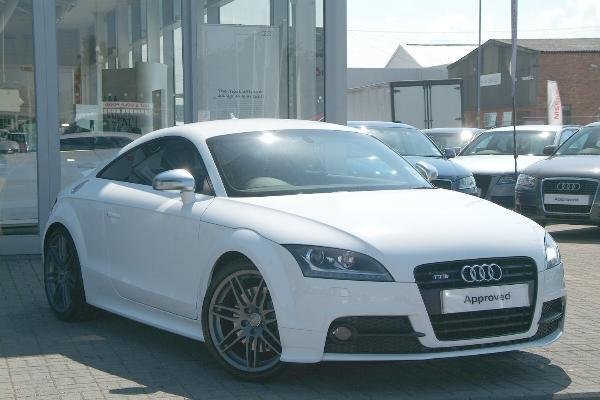

In [ ]:
from IPython.display import Image,display_jpeg
#display_jpeg(Image('cars_train/080.jpg'))
display_jpeg(Image('stanford-car/jpg/00001.jpg'))

In [ ]:
!ls -all